# 外国為替レートと経済指標との相関

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt

## 為替レートデータの読み込み

In [2]:
df_exrate = pd.read_excel('Foreign_JPY_18_23.xlsx', sheet_name='RawData')
df_exrate.head()

,date,USD,GBP,EUR,CAD,AUD,NZD
0,2018-01-04,112.75,152.30,135.35,89.83,88.22,79.88
1,2018-01-05,112.84,153.06,136.21,90.36,88.62,80.75
2,2018-01-09,113.15,153.50,135.43,91.15,88.82,81.23
3,2018-01-10,112.45,152.17,134.21,90.17,87.87,80.39
4,2018-01-11,111.52,150.64,133.30,88.93,87.83,80.32


## 原油価格データの読み込み

In [3]:
df_temp_1 = pd.read_excel('oil_price_18_23.xlsx', sheet_name='RawData')
df_temp_1.head()

,Date,Price,Open,High,Low
0,04/04/2023,80.81,80.42,80.91,80.41
1,04/03/2023,80.42,80.10,81.69,79.00
2,04/02/2023,80.51,80.27,81.58,80.22
3,03/31/2023,75.67,74.37,75.72,73.77
4,03/30/2023,74.37,72.98,74.63,72.61


In [4]:
# 日付文字列を日付値に変換する
df_petro = df_temp_1.assign(tdatetime = df_temp_1['Date'].apply(lambda s: dt.strptime(s, '%m/%d/%Y'))).\
    drop(columns='Date').rename(columns={'tdatetime':'date'})
df_petro.head()

,Price,Open,High,Low,date
0,80.81,80.42,80.91,80.41,2023-04-04
1,80.42,80.10,81.69,79.00,2023-04-03
2,80.51,80.27,81.58,80.22,2023-04-02
3,75.67,74.37,75.72,73.77,2023-03-31
4,74.37,72.98,74.63,72.61,2023-03-30


## 石炭価格データの読み込み

In [5]:
df_coal = pd.read_excel('coal_price_18_23.xlsx', sheet_name='RawData').rename(columns={'Date':'date'})
df_coal.head()

,date,Price,Open,High,Low
0,2023-04-03,200.00,197.00,198.00,197.00
1,2023-03-31,177.25,177.25,177.25,177.25
2,2023-03-30,176.75,176.75,176.75,176.75
3,2023-03-29,176.60,176.60,176.60,176.60
4,2023-03-28,176.50,176.50,176.50,176.50


## データを横連結する

In [6]:
# 日付をキーとして一つずつ横連結する（_xが原油価格,_yが石炭価格）
df_src = df_exrate.merge(df_petro,how='inner',on='date').merge(df_coal,how='inner',on='date')
df_src.head()

,date,USD,GBP,EUR,CAD,AUD,NZD,Price_x,Open_x,High_x,Low_x,Price_y,Open_y,High_y,Low_y
0,2018-01-04,112.75,152.30,135.35,89.83,88.22,79.88,62.01,61.96,62.21,61.59,104.95,105.00,105.00,105.00
1,2018-01-05,112.84,153.06,136.21,90.36,88.62,80.75,61.44,61.90,62.04,61.09,105.30,105.25,105.50,105.00
2,2018-01-09,113.15,153.50,135.43,91.15,88.82,81.23,62.96,61.92,63.48,61.80,107.00,107.00,107.00,107.00
3,2018-01-10,112.45,152.17,134.21,90.17,87.87,80.39,63.57,63.41,63.67,63.09,106.55,106.55,106.55,106.55
4,2018-01-11,111.52,150.64,133.30,88.93,87.83,80.32,63.80,63.50,64.77,63.43,106.10,106.10,106.10,106.10


In [7]:
## データ系列の階差をとる

In [8]:
df_diff = df_src.diff()[1:]
df_diff.head()

,date,USD,GBP,EUR,CAD,AUD,NZD,Price_x,Open_x,High_x,Low_x,Price_y,Open_y,High_y,Low_y
1,1 days,0.09,0.76,0.86,0.53,0.40,0.87,-0.57,-0.06,-0.17,-0.50,0.35,0.25,0.50,0.00
2,4 days,0.31,0.44,-0.78,0.79,0.20,0.48,1.52,0.02,1.44,0.71,1.70,1.75,1.50,2.00
3,1 days,-0.70,-1.33,-1.22,-0.98,-0.95,-0.84,0.61,1.49,0.19,1.29,-0.45,-0.45,-0.45,-0.45
4,1 days,-0.93,-1.53,-0.91,-1.24,-0.04,-0.07,0.23,0.09,1.10,0.34,-0.45,-0.45,-0.45,-0.45
5,1 days,-0.29,0.21,0.84,-0.05,0.05,0.56,0.50,0.07,-0.27,-0.37,-0.25,-0.25,-0.25,-0.25


## 相互相関係数を計算する

In [9]:
def cross_corr(a, b, s):
    # 標準化ベクトルを求める 
    a_diff = (a-a.mean())/a.std(ddof=0)
    b_diff = (b-b.mean())/b.std(ddof=0)
    # Compute the cross-correlation between the two signals
    corr = np.correlate(a_diff, b_diff, mode='same')
    # Plot the cross-correlation correlogram
    plt.plot(corr[:20])
    plt.xlabel('Lag')
    plt.ylabel('Cross-correlation')
    plt.title('Lag cross-correlation correlogram: '+s)
    plt.show()

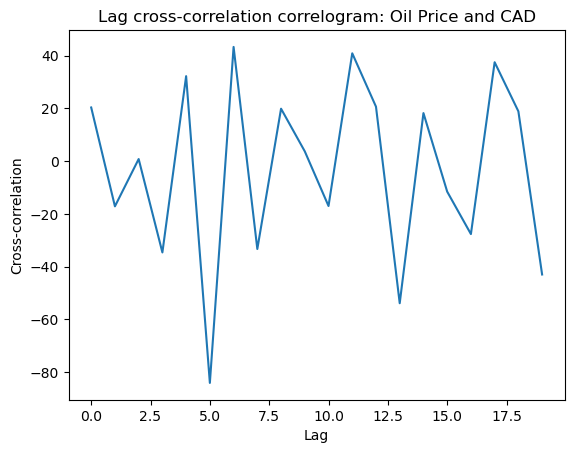

In [10]:
a = df_diff['Price_x'] 
b = df_diff['CAD']
s = 'Oil Price and CAD'
cross_corr(a, b, s)

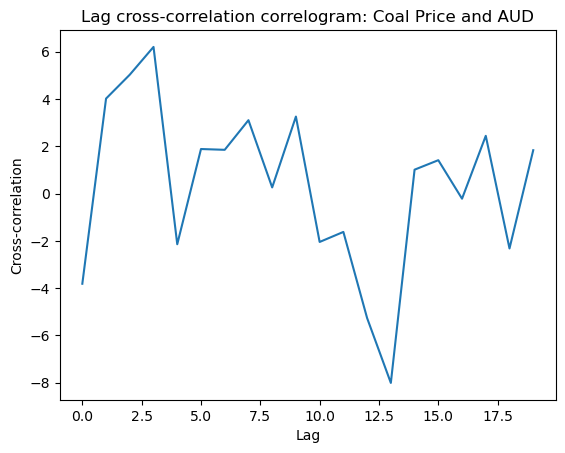

In [11]:
a = df_diff['Price_y'] 
b = df_diff['AUD']
s = 'Coal Price and AUD'
cross_corr(a, b, s)